In [10]:
import sys
import torch
from numpy import unravel_index as unravel
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import heapq
import math
import os
from collections import deque
import cv2

In [11]:
MAX_MEMORY = 100_000
BATCH_SIZE = 1000
LR = 0.001

In [12]:
action_dict = {'a': torch.tensor([0., -1.]), 'd': torch.tensor([0., 1.]), 'w': torch.tensor([-1., 0.]), 's': torch.tensor([1., 0.])}

def do(snake: torch.Tensor, action):
    reward = 0
    positions = snake.flatten().topk(2)[1]
    [pos_cur, pos_prev] = [torch.Tensor(unravel(x, snake.shape)) for x in positions]
    #print('direction', (pos_cur - pos_prev)) # Направление движения
    pos_next = (pos_cur + action) % torch.Tensor([snake.shape]).squeeze(0)

    pos_cur = pos_cur.int()
    pos_next = pos_next.int()

    # Проверка на столкновение
    if (snake[tuple(pos_next)] > 1).any():
        reward = -10
        return reward,(snake[tuple(pos_cur)] - 2).item()  # Возвращаем счёт (длина змейки минус 2)

    # Кушаем яблоко
    if snake[tuple(pos_next)] == -1:
        pos_food = (snake == 0).flatten().to(torch.float).multinomial(1)[0] # Генерируем позицию яблока
        snake[unravel(pos_food, snake.shape)] = -1 # Добавляем яблоко в игру
        reward = 10

    else: # Двигаемся в пустую клетку
        snake[snake > 0] -= 1  # Устанавливаем все значения в теле змеи равными 1

    snake[tuple(pos_next)] = snake[tuple(pos_cur)] + 1 # перемещаем голову
    return reward, (snake[tuple(pos_cur)] - 2).item()


In [13]:
class Neuro_BigBoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(1, 64, kernel_size=(3,3), padding = 1)
        self.drop = nn.Dropout(0.3)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(64, 128, kernel_size=(3,3), padding = 1)
        self.conv3=nn.Conv2d(128, 256, kernel_size=(3,3), padding = 1)
        self.conv4=nn.Conv2d(256, 512, kernel_size=(3,3), padding = 1)
        # self.fl = nn.Flatten()
        self.fc1=nn.Linear(128*8*8, 512)
        self.fc2=nn.Linear(512, 256)
        self.fc3=nn.Linear(256,3)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.drop(x)
        x = self.pool(x)
        x= F.relu(self.conv2(x))
        x = self.drop(x)
        x = F.relu(self.conv3(x))
        x = self.drop(x)
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.drop(x)
        x = self.pool(x)
        x = x.view(-1, 128*8*8)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = self.fc3(x)
        return x

    def save(self, file_name='model.pth'):
        model_folder_path = './model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)

class Neuro_NotSoBigBoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(17, 256)
        self.fc2=nn.Linear(256,3)

    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def save(self, file_name='model.pth'):
        model_folder_path = './model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)

In [14]:
class QTrainer:
    def __init__(self, model, lr, gamma):
        self.lr = lr
        self.gamma = gamma
        self.model = model
        self.model.load_state_dict(torch.load('model/model992.pth'))#, map_location=torch.device('cpu')))
        self.optimizer = torch.optim.Adam(model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()##.cuda()

    def train_step(self, state, action, reward, next_state, done):
        # print(state)
        state = torch.tensor(state, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.long)
        reward = torch.tensor(reward, dtype=torch.float)
        state = state#.cuda()
        next_state=next_state#.cuda()
        action =action#.cuda()
        reward#.cuda()
        # (n, x)
        # if len(state.shape) == 2:
        #     # (1, x)
        #     state = torch.unsqueeze(state, 0)#.cuda()
        #     next_state = torch.unsqueeze(next_state, 0)#.cuda()
        #     action = torch.unsqueeze(action, 0)#.cuda()
        #     reward = torch.unsqueeze(reward, 0)#.cuda()
        #     done = (done, )

        # 1: predicted Q values with current state
        # print(state.shape)
        pred = self.model(state.unsqueeze(0))

        target = pred.clone()
        
        Q_new = reward
        if not done:
            Q_new = reward + self.gamma * torch.max(self.model(next_state.unsqueeze(0)))
        # print(target.shape)
        target[0][torch.argmax(action).item()] = Q_new

        # 2: Q_new = r + y * max(next_predicted Q value) -> only do this if not done
        # pred.clone()
        # preds[argmax(action)] = Q_new
        self.optimizer.zero_grad()
        loss = self.criterion(pred, target)
        loss.backward()
        # print(loss)

        self.optimizer.step()

In [20]:
class Champion():
    def __init__(self, model):
        super().__init__()
        self.n_games = 0
        self.gamma = 0.9 # discount rate
        self.memory = deque(maxlen=MAX_MEMORY)
        self.model = model
        self.eps = 80
        self.trainer = QTrainer(self.model, lr=LR, gamma=self.gamma)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) # popleft if MAX_MEMORY is reached

    def train_long_memory(self):
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE) # list of tuples
        else:
            mini_sample = self.memory

        for state, action, reward, next_state, done in mini_sample:
           self.trainer.train_step(state, action, reward, next_state, done)

    def train_short_memory(self, state, action, reward, next_state, done):
        self.trainer.train_step(state, action, reward, next_state, done)

    def get_action(self, state):
        # random moves: tradeoff exploration / exploitation
        self.epsilon = (80-self.eps) - self.n_games
        final_move = [0,0,0]
        if random.randint(0, 200) < self.epsilon:
            move = random.randint(0, 2)
            final_move[move] = 1
        else:
            state = torch.tensor(state, dtype=torch.float)
            # print(state.shape)
            with torch.no_grad():
                prediction = self.model(state.unsqueeze(0))
                # print(prediction)
            move = torch.argmax(prediction).item()
            final_move[move] = 1

        return final_move




In [21]:
class Node:
    def __init__(self, x, y):
        self.x = x  # Координата x узла на карте
        self.y = y  # Координата y узла на карте
        self.g = 0  # Расстояние от начального узла до текущего узла
        self.h = 0  # Примерное расстояние от текущего узла до конечного узла
        self.f = 0  # Сумма g и h
        self.parent = None  # Родительский узел, используется для восстановления пути

    # Переопределяем оператор сравнения для сравнения узлов
    def __lt__(self, other):
        return self.f < other.f

    # Переопределяем оператор равенства для сравнения узлов
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y

    def __hash__(self):
        return hash((self.x, self.y))

# Определяем функцию для нахождения пути с помощью алгоритма A*
def astar(start, end, obstacles):

    # Создаем начальный и конечный узлы
    start_node = Node(start[0], start[1])
    end_node = Node(end[0], end[1])

    # Инициализируем очередь с приоритетами
    open_list = []
    heapq.heappush(open_list, start_node)

    # Инициализируем множество посещенных узлов
    closed_set = set()

    # Пока очередь с приоритетами не пуста
    while open_list:
        # Извлекаем узел с наименьшей оценкой f
        current_node = heapq.heappop(open_list)
        # Если текущий узел является конечным
        if current_node == end_node:
            # Восстанавливаем путь от конечного узла до начального
            path = []
            while current_node.parent is not None:
                path.append((current_node.x, current_node.y))
                current_node = current_node.parent
            return path[-1]

        # Добавляем текущий узел в множество посещенных узлов
        closed_set.add(current_node)

        # Получаем соседние узлы
        neighbors = []
        for dx in range(-1, 2):
            for dy in range(-1, 2):
                # Игнорируем текущий узел
                if not ((dx == -1 and dy == 0) or (dx == 0 and dy == 1) or (dx == 1 and dy == 0) or (dx == 0 and dy == -1)):
                    continue
                # Вычисляем координаты соседнего узла
                x = current_node.x + dx
                y = current_node.y + dy
                # Игнорируем узлы за пределами карты
                if x < 0 :
                    x=len(obstacles)-1
                if x>=len(obstacles):
                    x=0
                if y<0:
                    y=len(obstacles)-1
                if y>=len(obstacles):
                    y=0
                # Игнорируем препятствия
                if obstacles[x][y] == 1:
                    continue
                # Создаем новый узел и добавляем его в список соседей
                neighbor = Node(x, y)
                neighbors.append(neighbor)

        # Для каждого соседнего узла
        for neighbor in neighbors:
            # Если соседний узел уже был посещен, пропускаем его
            if neighbor in closed_set:
                continue

            # Вычисляем расстояние от начального узла до соседнего узла
            new_g = current_node.g + 1

            # Если соседний узел уже находится в очереди с приоритетами
            if nfo := next((n for n in open_list if n == neighbor), None):
                # Если новое расстояние до соседнего узла меньше, чем старое, обновляем значения g, h и f
                if new_g < nfo.g:
                    nfo.g = new_g
                    nfo.h = math.sqrt((end_node.x - nfo.x) ** 2 + (end_node.y - nfo.y) ** 2)
                    nfo.f = nfo.g + nfo.h
                    nfo.parent = current_node
                    # Обновляем приоритет соседнего узла в очереди с приоритетами
                    heapq.heapify(open_list)
            else:
                # Иначе добавляем соседний узел в очередь с приоритетами и вычисляем значения g, h и f
                neighbor.g = new_g
                neighbor.h = math.sqrt((end_node.x - neighbor.x) ** 2 + (end_node.y - neighbor.y) ** 2)
                neighbor.f = neighbor.g + neighbor.h
                neighbor.parent = current_node
                heapq.heappush(open_list, neighbor)

    # Если конечный узел недостижим, возвращаем None
    return None


In [22]:
class Snake:
    def __init__(self):
        self.field = torch.zeros((32, 32), dtype=torch.float)
        self.field[0, :32] = torch.Tensor([1, 2, 3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32])
        self.field[1,:32] = torch.Tensor([64,63,62,61,60,59,58,57,56,55,54,53,52,51,50,49,48,47,46,45,44,43,42,41,40,39,38,37,36,35,34,33]) # [хвост, голова, яблоко]
        # self.field[0, :4] = torch.Tensor([1, 2, 3,4]) # [хвост, голова, яблоко]
        # self.field[1,5] =  torch.Tensor([-1])
        self.field[2,1] = torch.Tensor([65])
        self.field[2,5] =  torch.Tensor([-1])
        self.a = torch.zeros((32, 32), dtype=torch.float)
        self.dirrection = torch.tensor([0,1])
        self.head_cords = [0,1]
        self.apple_cords = [0,2]
        self.neighbours = [[31,1],[0,0],[0,2],[1,1]]
        self.collision = [False, True, False, False]
        self.availible_passes = [torch.tensor([-1,0]),torch.tensor(self.dirrection),torch.tensor([1,0])]
        self.old_distance = 0
        self.new_distance = 0
        self.state = []

    def set_dirrection(self, dir):
        dir = torch.tensor(dir)
        if not torch.allclose(dir, self.dirrection):
            self.dirrection = dir
            if torch.allclose(dir, torch.tensor([0, 1])):
                self.availible_passes = [torch.tensor([-1, 0]), torch.tensor(self.dirrection), torch.tensor([1, 0])]
            if torch.allclose(dir, torch.tensor([1, 0])):
                self.availible_passes = [torch.tensor([0, 1]), torch.tensor(self.dirrection), torch.tensor([0, -1])]
            if torch.allclose(dir, torch.tensor([0, -1])):
                self.availible_passes = [torch.tensor([1, 0]), torch.tensor(self.dirrection), torch.tensor([-1, 0])]
            if torch.allclose(dir, torch.tensor([-1, 0])):
                self.availible_passes = [torch.tensor([0, -1]), torch.tensor(self.dirrection), torch.tensor([0, 1])]

    def set_head_cords(self,head):
        self.head_cords = head

    def set_apple_cords(self,apple):
        self.apple_cords = apple

    def set_neighbours(self):
        counter = 0
        for dx in range(-1, 2):
            for dy in range(-1, 2):
                # Игнорируем текущий узел
                if not ((dx == -1 and dy == 0) or (dx == 0 and dy == 1) or (dx == 1 and dy == 0) or (dx == 0 and dy == -1)):
                    continue
                x = self.head_cords[0] + dx
                y = self.head_cords[1] + dy

                if x < 0 :
                    x=31
                if x>=32:
                    x=0
                if y<0:
                    y=31
                if y>=32:
                    y=0

                self.neighbours[counter] = [x,y]
                if self.field[x][y] > 0:
                    self.collision[counter] = True
                else:
                    self.collision[counter] = False
                counter+=1

    def get_state(self):
        u=self.dirrection.tolist()==[-1,0]
        l = self.dirrection.tolist()==[0,-1]
        r =self.dirrection.tolist()==[0,1]
        d =self.dirrection.tolist()==[1,0]
        return [u,l,r,d,
                # self.head_cords[0]<self.apple_cords[0],self.head_cords[0]>self.apple_cords[0],
                # self.head_cords[1]<self.apple_cords[1],self.head_cords[1]>self.apple_cords[1],
                (u==self.collision[0]==1 or l==self.collision[1]==1 or r==self.collision[2]==1 or d==self.collision[3]==1),
                (u==self.collision[1]==1 or l==self.collision[3]==1 or r==self.collision[0]==1 or d==self.collision[2]==1),
                (u==self.collision[2]==1 or l==self.collision[0]==1 or r==self.collision[3]==1 or d==self.collision[1]==1)]

    def make_step(self, steps = 0):
        if steps == 0:
            passes = [self.availible_passes[0].clone(),self.availible_passes[1].clone(),self.availible_passes[2].clone()]
            step=self.availible_passes[np.argmax(steps)]
            reward = 0
            help = self.field.clone()
            a = torch.zeros(self.field.shape)
            a[self.field>0]=1
            a[self.field==self.field.max()]=2
            a[self.field<0]=-1
            head = [self.field.topk(1)[0].argmax().numpy(),self.field.topk(1)[1][self.field.topk(1)[0].argmax()].numpy()]
            apple = [(self.field.argmin()/32).int().item(),
                (self.field.argmin()%32).item()]
            head[1]=head[1][0]
            head_cords = [head[0].item(),head[1]]
            self.set_apple_cords(apple)
            # print(self,head_cords)
            self.set_head_cords(head_cords)
            # print(self.head_cords)
            self.set_neighbours()
            self.set_dirrection([1,0])
            self.state = self.get_state()
            
            for foot in self.availible_passes:
                reward, score = do(self.field, foot)
                a = torch.zeros(self.field.shape)
                a[self.field>0]=1
                a[self.field==self.field.max()]=2
                a[self.field<0]=-1
                head = [self.field.topk(1)[0].argmax().numpy(),self.field.topk(1)[1][self.field.topk(1)[0].argmax()].numpy()]
                apple = [(self.field.argmin()/32).int().item(),
                    (self.field.argmin()%32).item()]
                head[1]=head[1][0]
                head_cords = [head[0].item(),head[1]]
                self.set_apple_cords(apple)
                # print(self,head_cords)
                self.set_head_cords(head_cords)
                # print(self.head_cords)
                self.set_neighbours()
                self.set_dirrection(foot)
                self.state.extend(self.get_state()[-3:])


                self.field = help.clone()
                step=passes[np.argmax(steps)]
                reward = 0
                a = torch.zeros(self.field.shape)
                a[self.field>0]=1
                a[self.field==self.field.max()]=2
                a[self.field<0]=-1
                head = [self.field.topk(1)[0].argmax().numpy(),self.field.topk(1)[1][self.field.topk(1)[0].argmax()].numpy()]
                apple = [(self.field.argmin()/32).int().item(),
                    (self.field.argmin()%32).item()]
                head[1]=head[1][0]
                head_cords = [head[0].item(),head[1]]
                self.set_apple_cords(apple)
                # print(self,head_cords)
                self.set_head_cords(head_cords)
                # print(self.head_cords)
                self.set_neighbours()
                self.set_dirrection([1,0])
                
        else:
            passes = [self.availible_passes[0].clone(),self.availible_passes[1].clone(),self.availible_passes[2].clone()]
            step=self.availible_passes[np.argmax(steps)]
            reward = 0
            help = self.field.clone()
            reward, score = do(self.field, step)#, steps_before_eaten_apple)
            
            a = torch.zeros(self.field.shape)
            a[self.field>0]=1
            a[self.field==self.field.max()]=2
            a[self.field<0]=-1
            head = [self.field.topk(1)[0].argmax().numpy(),self.field.topk(1)[1][self.field.topk(1)[0].argmax()].numpy()]
            apple = [(self.field.argmin()/32).int().item(),
                (self.field.argmin()%32).item()]
            head[1]=head[1][0]
            head_cords = [head[0].item(),head[1]]
            self.set_apple_cords(apple)
            # print(self,head_cords)
            self.set_head_cords(head_cords)
            # print(self.head_cords)
            self.set_neighbours()
            self.set_dirrection(step)
            self.state = self.get_state()
            
            for foot in self.availible_passes:
                reward, score = do(self.field, foot)
                a = torch.zeros(self.field.shape)
                a[self.field>0]=1
                a[self.field==self.field.max()]=2
                a[self.field<0]=-1
                head = [self.field.topk(1)[0].argmax().numpy(),self.field.topk(1)[1][self.field.topk(1)[0].argmax()].numpy()]
                apple = [(self.field.argmin()/32).int().item(),
                    (self.field.argmin()%32).item()]
                head[1]=head[1][0]
                head_cords = [head[0].item(),head[1]]
                self.set_apple_cords(apple)
                # print(self,head_cords)
                self.set_head_cords(head_cords)
                # print(self.head_cords)
                self.set_neighbours()
                self.set_dirrection(foot)
                self.state.extend(self.get_state()[-3:])


                self.field = help.clone()
                step=passes[np.argmax(steps)]
                reward = 0
                reward, score = do(self.field, step)#, steps_before_eaten_apple)
                a = torch.zeros(self.field.shape)
                a[self.field>0]=1
                a[self.field==self.field.max()]=2
                a[self.field<0]=-1
                head = [self.field.topk(1)[0].argmax().numpy(),self.field.topk(1)[1][self.field.topk(1)[0].argmax()].numpy()]
                apple = [(self.field.argmin()/32).int().item(),
                    (self.field.argmin()%32).item()]
                head[1]=head[1][0]
                head_cords = [head[0].item(),head[1]]
                self.set_apple_cords(apple)
                # print(self,head_cords)
                self.set_head_cords(head_cords)
                # print(self.head_cords)
                self.set_neighbours()
                self.set_dirrection(step)
    
        
        a_np = a.numpy()
        a[self.field<0]=10
        cv2.namedWindow('image', cv2.WINDOW_NORMAL)
        cv2.imshow('image', a_np)
        cv2.waitKey(1)
        # cv2.destroyAllWindows()
        done = False
        if reward == -10:
            done = True
        return reward, done, score


In [23]:

plot_scores = []
plot_mean_scores = []
total_score = 0
record = 0
model = Neuro_NotSoBigBoss()#.cuda()
agent = Champion(model)
game = Snake()
reward_per_long_moves = 0
reward0_in_a_row=0
new_distance = 0
apple_eaten = 0
old_apple_cords = []
new_apple_cords = []
old_dirrection = torch.tensor([])
new_dirrection = torch.tensor([])
bad = 0
while True:
    # get old state
    game.make_step()
    state_old = game.state
    state_old.append(bad)
    old_apple_cords = game.apple_cords
    old_dirrection = game.dirrection
    # get move
    final_move = agent.get_action(state_old)
    # perform move and get new state
    game.old_distance = abs(game.head_cords[0]-game.apple_cords[0])+abs(game.head_cords[1]-game.apple_cords[1])
    reward, done, score = game.make_step(final_move)
    new_apple_cords = game.apple_cords
    game.new_distance = abs(game.head_cords[0]-game.apple_cords[0])+abs(game.head_cords[1]-game.apple_cords[1])
    new_dirrection = game.dirrection
    if new_dirrection.tolist()==old_dirrection.tolist() and reward == 0:
        bad+=1
        if reward == 0 and bad>32:
            reward = -bad/32
    else:
        bad = 0
    if bad>65:
        reward = -10
        bad = 0
        # print(new_dirrection.tolist(), old_dirrection.tolist())
    if not new_apple_cords == old_apple_cords:
        game.new_distance=0
    if new_distance>31:
        new_distance = 62 - new_distance
    if reward == 10:
        apple_eaten+=1
        reward=13
        bad = 0
    #     if reward0_in_a_row<70:
    #         reward+=5
    #     else:
    #         reward-=5*apple_eaten
        reward0_in_a_row=0

    if reward == -bad/32 or reward==0:
        # reward = -0.25
    #     if reward == 0:
        # reward += abs(32-game.new_distance)/8
        # if game.new_distance>game.old_distance:
        #     reward = -reward
    # if reward == -0.25:
        reward0_in_a_row+=1
        # if reward0_in_a_row > 65:
        #     reward -= reward0_in_a_row/100
        if reward0_in_a_row>1400:
            reward = -10
    # print(reward)
    if reward == -10:
        apple_eaten=0
        reward == -20
        if done == True:
            reward = -40 - score*5 
            if score > record:
                reward = -10 
        else:
            reward = -20 - score*5
        done = True
    #     reward = -5
        # if score < record:
        #     reward =-(score*record)*10
        #     if reward < -100:
        #         reward = -100
        reward0_in_a_row=0

    state_new = game.state
    state_new.append(bad>33)

    # train short memory
    agent.train_short_memory(state_old, final_move, reward, state_new, done)

    # remember
    agent.remember(state_old, final_move, reward, state_new, done)

    if done:
        print(game.collision)
        # train long memory, plot result
        game=Snake()
        agent.n_games += 1
        agent.train_long_memory()

        if score > record:
            record = score
            agent.model.save()


        print('Game', agent.n_games, 'Score', score, 'Record:', record)

        plot_scores.append(score)
        total_score += score
        mean_score = total_score / agent.n_games
        plot_mean_scores.append(mean_score)

C:\Users\User\AppData\Local\Temp\ipykernel_12640\1545684346.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.availible_passes = [torch.tensor([-1,0]),torch.tensor(self.dirrection),torch.tensor([1,0])]
C:\Users\User\AppData\Local\Temp\ipykernel_12640\1545684346.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.availible_passes = [torch.tensor([0, 1]), torch.tensor(self.dirrection), torch.tensor([0, -1])]
C:\Users\User\AppData\Local\Temp\ipykernel_12640\1545684346.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dir = t

KeyboardInterrupt: 

In [ ]:

snake = Snake()
reward = 0
while True:
    a = torch.zeros(snake.field.shape)
    a[snake.field>0]=1
    a[snake.field==snake.field.max()]=2
    a[snake.field<0]=-1
    head = [snake.field.topk(1)[0].argmax().numpy(),snake.field.topk(1)[1][snake.field.topk(1)[0].argmax()].numpy()]
    apple = [(snake.field.argmin()/32).int().item(),
        (snake.field.argmin()%32).item()]
    head[1]=head[1][0]
    head_cords = [head[0].item(),head[1]]
    snake.set_apple_cords(apple)
    snake.set_head_cords(head_cords)
    snake.set_neighbours()
    if reward == -100:
        break
    path = astar( head_cords, apple, a)
    if path == None:
        break
    cords = np.array(path)
    # print(cords, np.array(head_cords))
    cords-=np.array(head_cords)
    if cords[0]==-31:
        cords[0]=1
    if cords[0]==31:
        cords[0]=-1
    if cords[1]==-31:
        cords[1]=1
    if cords[1]==31:
        cords[1]=-1
    # fig, ax = plt.subplots(1, 1)
    # img = ax.imshow(a)
    action = {'val': 1}
    n = 0
    score = None
    # img.set_data(a)
    cords_list=cords.tolist()
    snake.set_dirrection(cords_list)
    reward, score = do(snake.field, cords)
    n += 1


C:\Users\User\AppData\Local\Temp\ipykernel_19632\1708204886.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.availible_passes = [torch.tensor([-1,0]),torch.tensor(self.dirrection),torch.tensor([1,0])]
C:\Users\User\AppData\Local\Temp\ipykernel_19632\1708204886.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.availible_passes = [torch.tensor([0, 1]), torch.tensor(self.dirrection), torch.tensor([0, -1])]
C:\Users\User\AppData\Local\Temp\ipykernel_19632\1708204886.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.av

KeyboardInterrupt: 

C:\Users\User\AppData\Local\Temp\ipykernel_19712\3910024154.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.availible_passes = [torch.tensor([-1,0]),torch.tensor(self.dirrection),torch.tensor([1,0])]
C:\Users\User\AppData\Local\Temp\ipykernel_19712\3910024154.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.availible_passes = [torch.tensor([0, 1]), torch.tensor(self.dirrection), torch.tensor([0, -1])]
C:\Users\User\AppData\Local\Temp\ipykernel_19712\3910024154.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dir = t

[False, False, False, True, False, False, True, False, False, False, False, False, True, False, False, False, False, False, False, True]


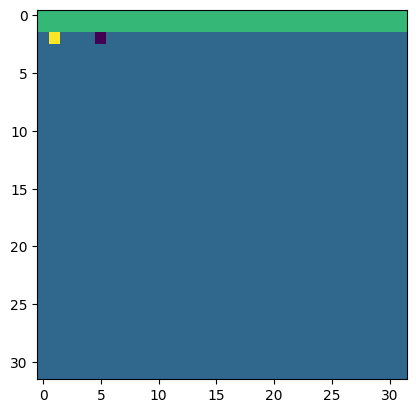

In [18]:
snake=Snake()
fig, ax = plt.subplots(1, 1)
snake.availible_passes
a = torch.zeros(snake.field.shape)
a[snake.field>0]=1
a[snake.field==snake.field.max()]=2
a[snake.field<0]=-1
# print(a)
img = ax.imshow(a)
snake.make_step()
print(snake.state)

[False, False, True, False, False, False, True, False, False, True, False, True, True, False, False, True, False, False, False, False]
[False, False, True, False, False, False, True, False, False, True, False]


C:\Users\User\AppData\Local\Temp\ipykernel_19712\3910024154.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dir = torch.tensor(dir)
C:\Users\User\AppData\Local\Temp\ipykernel_19712\3910024154.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.availible_passes = [torch.tensor([-1, 0]), torch.tensor(self.dirrection), torch.tensor([1, 0])]
C:\Users\User\AppData\Local\Temp\ipykernel_19712\3910024154.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.availible_passes = [torch.tensor([0, -1]), torch.tensor(self.dirrection), t

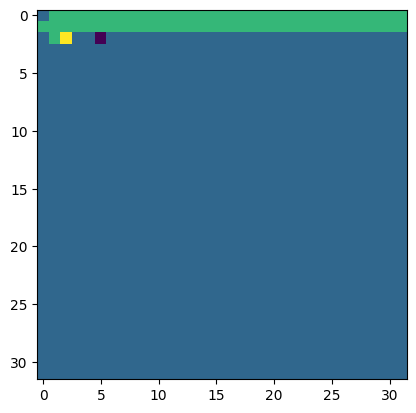

In [19]:
n=0
fig, ax = plt.subplots(1, 1)
a = torch.zeros(snake.field.shape)
# print(a)
while n<1:
    # img.set_data(a)
    reward, done, score = snake.make_step([1,0,0])
    n += 1
    # img.set_data(a)
    

# print(reward, score)
# print(score)

a[snake.field>0]=1
a[snake.field==snake.field.max()]=2
a[snake.field<0]=-1
img = ax.imshow(a)
state = snake.state
print(state)
print(snake.get_state())



In [25]:

plot_scores = []
plot_mean_scores = []
total_score = 0
record = 0
model = Neuro_NotSoBigBoss()#.cuda()
agent = Champion(model)
game = Snake()
reward_per_long_moves = 0
reward0_in_a_row=0
new_distance = 0
apple_eaten = 0
old_apple_cords = []
new_apple_cords = []
old_dirrection = torch.tensor([])
new_dirrection = torch.tensor([])
bad = 0
while True:
    # get old state
    game.make_step()
    state_old = game.state
    state_old.append(bad)
    old_apple_cords = game.apple_cords
    old_dirrection = game.dirrection
    # get move
    final_move = agent.get_action(state_old)
    # perform move and get new state
    game.old_distance = abs(game.head_cords[0]-game.apple_cords[0])+abs(game.head_cords[1]-game.apple_cords[1])
    reward, done, score = game.make_step(final_move)
    new_apple_cords = game.apple_cords
    game.new_distance = abs(game.head_cords[0]-game.apple_cords[0])+abs(game.head_cords[1]-game.apple_cords[1])
    new_dirrection = game.dirrection
    if new_dirrection.tolist()==old_dirrection.tolist() and reward == 0:
        bad+=1
        if reward == 0 and bad>32:
            reward = -bad/32
    else:
        bad = 0
    if bad>65:
        reward = -10
        bad = 0
        # print(new_dirrection.tolist(), old_dirrection.tolist())
    if not new_apple_cords == old_apple_cords:
        game.new_distance=0
    if new_distance>31:
        new_distance = 62 - new_distance
    if reward == 10:
        apple_eaten+=1
        reward=13
        bad = 0
    #     if reward0_in_a_row<70:
    #         reward+=5
    #     else:
    #         reward-=5*apple_eaten
        reward0_in_a_row=0

    if reward == -bad/32 or reward==0:
        # reward = -0.25
    #     if reward == 0:
        # reward += abs(32-game.new_distance)/8
        # if game.new_distance>game.old_distance:
        #     reward = -reward
    # if reward == -0.25:
        reward0_in_a_row+=1
        # if reward0_in_a_row > 65:
        #     reward -= reward0_in_a_row/100
        if reward0_in_a_row>1400:
            reward = -10
    # print(reward)
    if reward == -10:
        apple_eaten=0
        reward == -20
        if done == True:
            reward = -40 - score*5 
            if score > record:
                reward = -10 
        else:
            reward = -20 - score*5
        done = True
    #     reward = -5
        # if score < record:
        #     reward =-(score*record)*10
        #     if reward < -100:
        #         reward = -100
        reward0_in_a_row=0

    state_new = game.state
    state_new.append(bad>33)

    # train short memory
    # agent.train_short_memory(state_old, final_move, reward, state_new, done)

    # # remember
    # agent.remember(state_old, final_move, reward, state_new, done)

    if done:
        # print(game.collision)
        # train long memory, plot result
        game=Snake()
        agent.n_games += 1
        # agent.train_long_memory()

        if score > record:
            record = score
            # agent.model.save()


        print('Game', agent.n_games, 'Score', score, 'Record:', record)

        plot_scores.append(score)
        total_score += score
        mean_score = total_score / agent.n_games
        plot_mean_scores.append(mean_score)

C:\Users\User\AppData\Local\Temp\ipykernel_12640\1545684346.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.availible_passes = [torch.tensor([-1,0]),torch.tensor(self.dirrection),torch.tensor([1,0])]
C:\Users\User\AppData\Local\Temp\ipykernel_12640\1545684346.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.availible_passes = [torch.tensor([0, 1]), torch.tensor(self.dirrection), torch.tensor([0, -1])]
C:\Users\User\AppData\Local\Temp\ipykernel_12640\1545684346.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dir = t

Game 1 Score 993.0 Record: 993.0


KeyboardInterrupt: 

In [ ]:
game.make_step([0,0,1])

In [ ]:
game.dirrection

In [ ]:
game.collision

In [ ]:
game.get_state()

In [ ]:
game.head_cords

In [ ]:
a = [[i for i in range(32,64)]]
len(a[0][::-1])

In [ ]:
field = torch.zeros((32, 32), dtype=torch.float)
field[0, :32] = torch.Tensor([i for i in range(1,33)])
print(field[0])
for i in range (32,321):
    field[int(i/32)][i%32] = i+1
    # if field[int(i/32)][i%32-1] == 0:
    #     field[int(i/32)][i%32-1] = int(i/32)*32
# field[1][0] = 33
for i in range (1,11):
    field[i] = field[i].flip(0)
    print(field[i])

In [ ]:
field[0][::-1]

In [9]:

plot_scores = []
plot_mean_scores = []
total_score = 0
record = 0
model = Neuro_BigBoss()#.cuda()
agent = Champion(model)
game = Snake()
reward_per_long_moves = 0
reward0_in_a_row=0
new_distance = 0
apple_eaten = 0
old_apple_cords = []
new_apple_cords = []
old_dirrection = torch.tensor([])
new_dirrection = torch.tensor([])
bad = 0
while True:
    # get old state
    a = torch.zeros(game.field.shape)
    a[game.field>0]=1
    a[game.field==game.field.max()]=2
    a[game.field<0]=-1
    state_old = a
    old_apple_cords = game.apple_cords
    old_dirrection = game.dirrection
    # get move
    final_move = agent.get_action(a)
    # perform move and get new state
    game.old_distance = abs(game.head_cords[0]-game.apple_cords[0])+abs(game.head_cords[1]-game.apple_cords[1])
    reward, done, score = game.make_step(final_move)
    new_apple_cords = game.apple_cords
    game.new_distance = abs(game.head_cords[0]-game.apple_cords[0])+abs(game.head_cords[1]-game.apple_cords[1])
    new_dirrection = game.dirrection
    if new_dirrection.tolist()==old_dirrection.tolist() and reward == 0:
        bad+=1
        if reward == 0 and bad>32:
            reward = -bad/32
    else:
        bad = 0
    if bad>65:
        reward = -10
        bad = 0
        # print(new_dirrection.tolist(), old_dirrection.tolist())
    if not new_apple_cords == old_apple_cords:
        game.new_distance=0
    if new_distance>31:
        new_distance = 62 - new_distance
    if reward == 10:
        apple_eaten+=1
        reward=13
        bad = 0
    #     if reward0_in_a_row<70:
    #         reward+=5
    #     else:
    #         reward-=5*apple_eaten
        reward0_in_a_row=0

    if reward == -bad/32 or reward==0:
        # reward = -0.25
    #     if reward == 0:
        reward += abs(32-game.new_distance)/8
        if game.new_distance>game.old_distance:
            reward = -reward
    # if reward == -0.25:
        reward0_in_a_row+=1
        if reward0_in_a_row > 65:
            reward -= reward0_in_a_row/100
        if reward0_in_a_row>1400:
            reward = -10
    # print(reward)
    if reward == -10:
        apple_eaten=0
        reward == -20
        if done == True:
            reward = -40 - score*5 
            if score > record:
                reward = -10 
        else:
            reward = -20 - score*5
        done = True
    #     reward = -5
        # if score < record:
        #     reward =-(score*record)*10
        #     if reward < -100:
        #         reward = -100
        reward0_in_a_row=0
    a = torch.zeros(game.field.shape)
    a[game.field>0]=1
    a[game.field==game.field.max()]=2
    a[game.field<0]=-1
    state_new = a

    # train short memory

    # remember

    if done:
        
        # train long memory, plot result
        game=Snake()
        agent.n_games += 1

        if score > record:
            record = score


        print('Game', agent.n_games, 'Score', score, 'Record:', record)

        plot_scores.append(score)
        total_score += score
        mean_score = total_score / agent.n_games
        plot_mean_scores.append(mean_score)

C:\Users\User\AppData\Local\Temp\ipykernel_3228\3117139751.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.availible_passes = [torch.tensor([-1,0]),torch.tensor(self.dirrection),torch.tensor([1,0])]
C:\Users\User\AppData\Local\Temp\ipykernel_3228\1792586125.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float)
C:\Users\User\AppData\Local\Temp\ipykernel_3228\3117139751.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dir = torch.tensor(dir)


tensor([[-119.4418,  -74.7779,  -85.8156]])
tensor([[-122.4726,  -85.8184,  -90.2587]])
tensor([[-94.5881, -60.5124, -68.8045]])
tensor([[-93.0920, -60.9890, -68.5331]])
tensor([[-83.7780, -60.3364, -67.0102]])
tensor([[-100.5996,  -69.1402,  -72.0685]])
tensor([[-120.8778,  -74.2987,  -83.0255]])
tensor([[-126.2477,  -83.3240,  -95.6853]])
tensor([[-97.9060, -64.2938, -74.6057]])
tensor([[-122.1533,  -77.1641,  -87.5124]])
tensor([[-101.4965,  -63.9642,  -74.5733]])
tensor([[-88.1297, -61.0468, -68.8043]])
tensor([[-105.6127,  -78.6404,  -88.6391]])
tensor([[-106.0010,  -70.0267,  -80.6509]])
tensor([[-104.9383,  -62.3359,  -75.6329]])
tensor([[-99.4105, -68.7354, -78.5908]])
tensor([[-125.3804,  -86.9275,  -96.4846]])
tensor([[-123.2146,  -80.4576,  -87.6465]])
tensor([[-128.6012,  -94.6383, -105.2981]])
tensor([[-99.5565, -64.8728, -70.1497]])
tensor([[-123.4165,  -81.4098,  -89.5375]])
tensor([[-99.4911, -65.7871, -74.9586]])
tensor([[-129.3459,  -85.2627, -102.3314]])
tensor([[-13

C:\Users\User\AppData\Local\Temp\ipykernel_3228\3117139751.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.availible_passes = [torch.tensor([0, 1]), torch.tensor(self.dirrection), torch.tensor([0, -1])]
C:\Users\User\AppData\Local\Temp\ipykernel_3228\3117139751.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.availible_passes = [torch.tensor([1, 0]), torch.tensor(self.dirrection), torch.tensor([-1, 0])]


tensor([[-83.6925, -55.2452, -62.8950]])
tensor([[-81.2484, -55.3435, -58.0458]])
tensor([[-73.7196, -51.2302, -56.9235]])
tensor([[-68.3723, -45.8311, -52.0650]])
tensor([[-33.3764, -23.3259, -24.9669]])
tensor([[-55.7973, -35.4454, -39.1767]])
tensor([[-50.1714, -37.9578, -36.6905]])
tensor([[-60.3619, -43.3977, -46.1997]])
tensor([[-59.3898, -36.5293, -41.9235]])
tensor([[-65.3615, -44.2446, -47.4024]])
tensor([[-66.0641, -39.9781, -45.5671]])
tensor([[-42.7375, -31.9486, -33.0656]])
tensor([[-66.3319, -41.8540, -46.4857]])
tensor([[-53.0199, -36.1342, -38.5950]])
tensor([[-53.7191, -36.1890, -38.7949]])
tensor([[-47.2052, -32.0289, -34.2587]])
tensor([[-55.5967, -37.3542, -41.9351]])
tensor([[-32.1208, -23.9170, -25.1120]])
tensor([[-54.0895, -35.4814, -40.8368]])
tensor([[-34.2666, -24.0938, -25.8461]])
tensor([[-41.6648, -29.6452, -32.5587]])
tensor([[-37.3750, -25.4919, -25.7670]])
tensor([[-53.2578, -38.0997, -41.0058]])
tensor([[-59.9634, -40.8755, -43.2077]])
tensor([[-35.410

C:\Users\User\AppData\Local\Temp\ipykernel_3228\3117139751.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.availible_passes = [torch.tensor([0, -1]), torch.tensor(self.dirrection), torch.tensor([0, 1])]
C:\Users\User\AppData\Local\Temp\ipykernel_3228\3117139751.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.availible_passes = [torch.tensor([-1, 0]), torch.tensor(self.dirrection), torch.tensor([1, 0])]


Game 23 Score 64.0 Record: 64.0
tensor([[-122.1010,  -76.7745,  -89.3387]])
tensor([[-116.4211,  -75.7213,  -81.7708]])
tensor([[-112.2957,  -76.1113,  -81.5976]])
tensor([[-124.0366,  -87.2895,  -92.2668]])
tensor([[-109.1130,  -73.7418,  -81.2753]])
tensor([[-98.0270, -64.0328, -71.9204]])
tensor([[-102.8496,  -71.5100,  -81.0088]])
tensor([[-95.0565, -65.1974, -76.6516]])
tensor([[-114.5051,  -73.6338,  -80.6049]])
tensor([[-122.6620,  -74.9671,  -79.9495]])
tensor([[-93.5585, -60.2854, -66.1190]])
tensor([[-127.7441,  -82.9823,  -91.8177]])
tensor([[-143.1497,  -91.0474, -101.2997]])
tensor([[-133.7437,  -86.7312, -100.0902]])
tensor([[-98.2331, -69.0265, -69.3859]])
tensor([[-145.5290,  -97.2414, -108.8540]])
tensor([[-122.3953,  -84.2854,  -92.2955]])
tensor([[-108.4408,  -65.3677,  -75.5204]])
tensor([[-113.9977,  -79.2282,  -88.5134]])
tensor([[-100.2513,  -64.3014,  -72.0703]])
tensor([[-109.0061,  -72.9748,  -84.8820]])
tensor([[-134.8972,  -91.2572, -106.1218]])
tensor([[-11

KeyboardInterrupt: 

In [22]:
i = [1,2,3,4]
print(i[-3:])

[2]


In [42]:
game = Snake()
reward, done,score = game.make_step([0,0,1])
print(game.get_state())
print(game.state)

[False, False, False, True, False, True, True, False, False, False, False]
[False, False, False, True, False, True, True, False, False, False, False, False, False, False, False, False, False, False, False, True]


C:\Users\User\AppData\Local\Temp\ipykernel_19632\83478123.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.availible_passes = [torch.tensor([-1,0]),torch.tensor(self.dirrection),torch.tensor([1,0])]
C:\Users\User\AppData\Local\Temp\ipykernel_19632\83478123.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dir = torch.tensor(dir)
C:\Users\User\AppData\Local\Temp\ipykernel_19632\83478123.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.availible_passes = [torch.tensor([0, 1]), torch.tensor(self.dirrection), torch.tensor

In [25]:
import requests
print(requests.get('http://sob@sob@ka.tasks.nsuctf.ru').text)

<html>
<head><title>503 Service Temporarily Unavailable</title></head>
<body>
<center><h1>503 Service Temporarily Unavailable</h1></center>
<hr><center>nginx</center>
</body>
</html>



In [26]:
import requests
from bs4 import BeautifulSoup
 
 
url = 'http://sob@ka.tasks.nsuctf.ru/'
reqs = requests.get(url)
soup = BeautifulSoup(reqs.text, 'html.parser')
 
urls = []
for link in soup.find_all('a'):
    print(link.get('href'))